In [1]:
import h5py 
import scipy 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tkinter 
import scipy.interpolate 
from sklearn.neighbors import KernelDensity 
from scipy.stats import gaussian_kde 

Number of frames: 3425
Number of raw hits: 1824
Number of real hits (intensity > 0): 1823
Average intensity: 35664.19857377948
Standard deviation intensity: 4139.77239603976
Minimum intensity: 32815.0
Maximum intensity: 139474.0
Average sixth-root intensity: 5.733620050328822
Standard deviation sixth-root intensity: 0.08648834877614459
Minimum sixth-root intensity: 5.658205737703025
Maximum sixth-root intensity: 7.201376923819016


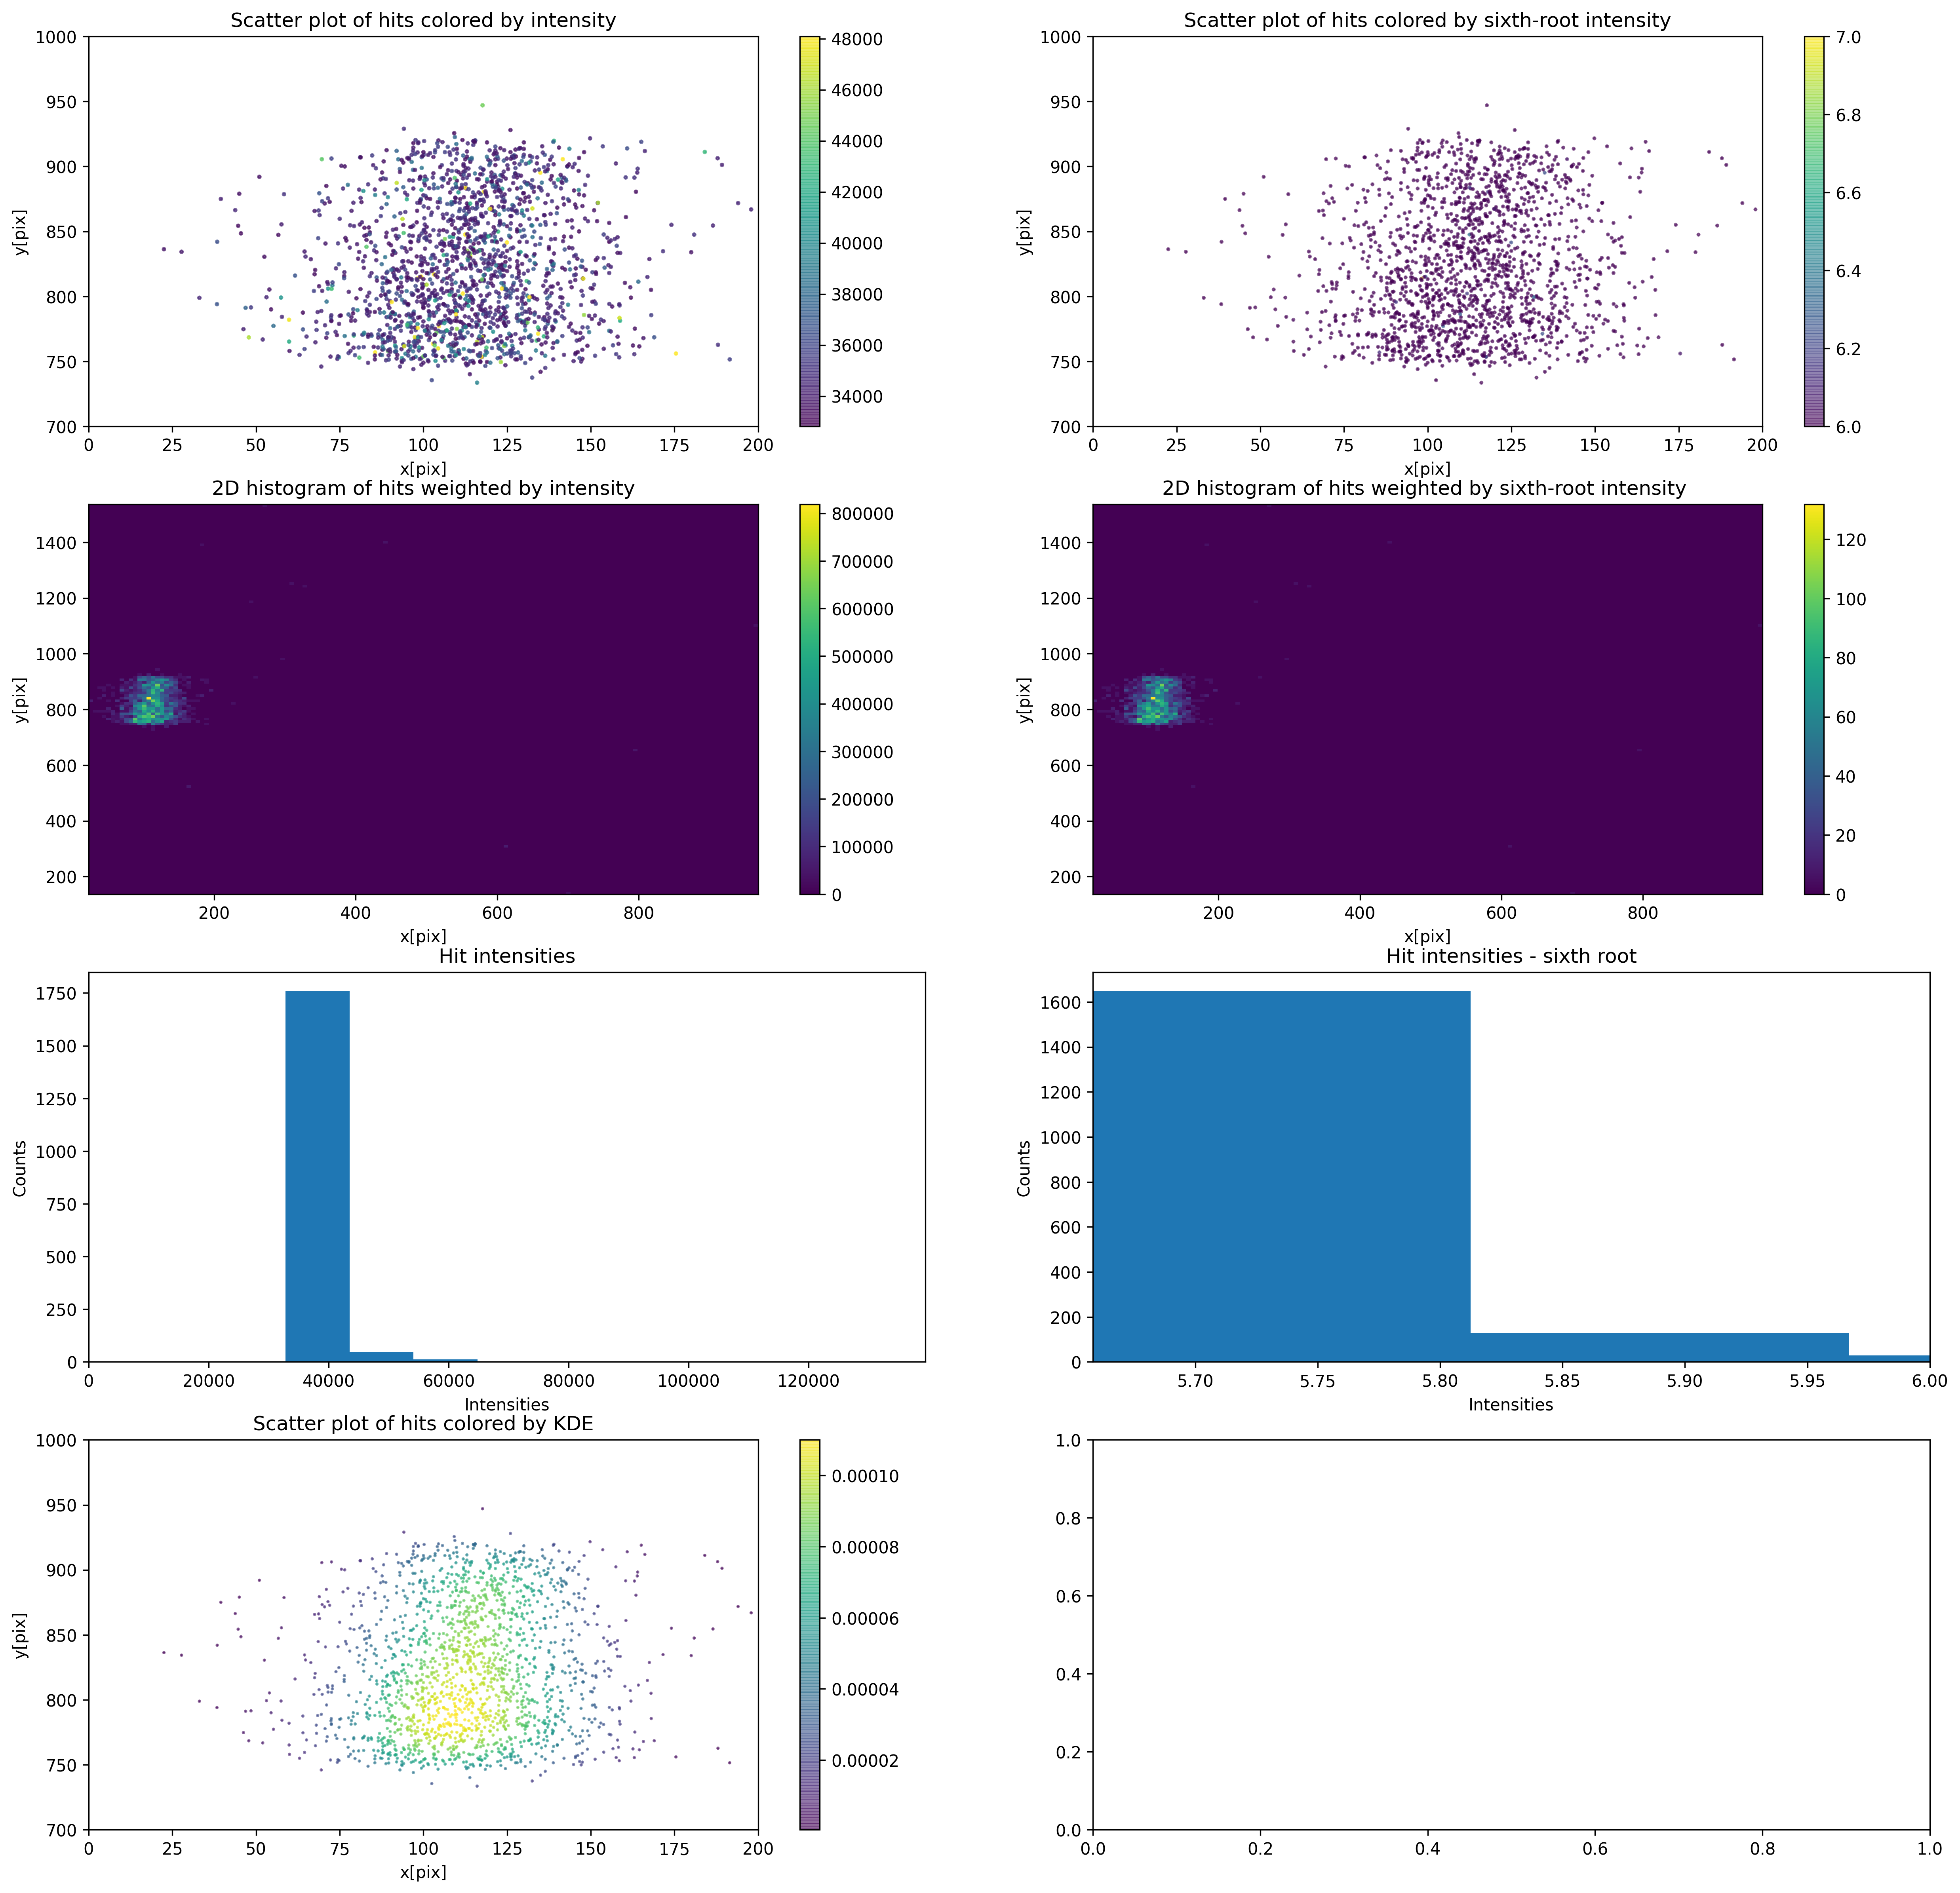

In [2]:
df = pd.DataFrame(columns = ['nr_hits','sum_hit_intensities','max_density','fwhm in um', 'fwhm in pixels', 'nr_frames', 'mean hit intensity','mean hits per frame']) 

hits = 0 
frames = 0 
hit_intensity = 0 
hit_intensities = np.empty(shape = (0)) 
hit_x = np.empty(shape = (0)) 
hit_y = np.empty(shape = (0)) 
########################### 
#f_name = '/Users/tongyou/Desktop/check_intensity/analyse_2/dat496_bg_analysis/spts.cxi' 
#f_name = '/Users/tongyou/Desktop/check_intensity/analyse_2/d504bg_analysis_ws_13/spts.cxi' 
#f_name = '/Users/tongyou/Desktop/check_intensity/analyse_2/d504bg_analysis_ws_17/spts.cxi' 
#f_name = '/Users/tongyou/Desktop/check_intensity/analyse_2/d504bg_analysis_ws_19/spts.cxi' 
#f_name = '/Users/tongyou/Desktop/check_intensity/analyse_2/d504bg_analysis_ws_21/spts.cxi' 
#f_name = '/Users/tongyou/Desktop/check_intensity/analyse_2/d504bg_analysis_ws_23/spts.cxi' 
#f_name = '/Users/tongyou/Desktop/check_intensity/analyse_2/d504bg_analysis_ws_29/spts.cxi' 
#f_name = '/Users/tongyou/Desktop/check_intensity/analyse_2/out_med_analysis/spts.cxi' 
f_name = '/Users/tongyou/Desktop/check_intensity/analyse_2/out_med_p_90_analysis/spts.cxi' 
f = h5py.File(f_name, 'r') 
########################## 

frames += f['/5_detect/n'].shape[0] 
print('Number of frames:', frames) 

for i in range(0, f['/5_detect/x'].shape[0]): # frame counter 
    for j in range(0, f['/5_detect/n'][i]): # particle counter 
        if f['/6_analyse/peak_sum'][i, j] > 0: # ignore hits with intensity lower than zero 
            hit_x = np.append(hit_x, f['/5_detect/x'][i, j]) 
            hit_y = np.append(hit_y, f['/5_detect/y'][i, j]) 

hits += np.sum(f['/5_detect/n']) 
print('Number of raw hits:', hits) 
a = np.array(f['/6_analyse/peak_sum']) 
real_hits = np.sum((a > 0)) 
print('Number of real hits (intensity > 0):', real_hits) 
 
# Intensity 
hit_intensities = np.append(hit_intensities, a[a > 0]) 
print('Average intensity:', np.mean(hit_intensities)) 
print('Standard deviation intensity:', np.std(hit_intensities)) 
print('Minimum intensity:', np.min(hit_intensities)) 
print('Maximum intensity:', np.max(hit_intensities)) 
# Sixth-root intensity 
hit_intensities_sixth_root = hit_intensities ** (1/6) 
print('Average sixth-root intensity:', np.mean(hit_intensities_sixth_root)) 
print('Standard deviation sixth-root intensity:', np.std(hit_intensities_sixth_root)) 
print('Minimum sixth-root intensity:', np.min(hit_intensities_sixth_root)) 
print('Maximum sixth-root intensity:', np.max(hit_intensities_sixth_root)) 

fig, ax = plt.subplots(4 , 2, figsize = (20, 20), dpi = 300) 

xmin = hit_x.min() 
xmax = hit_x.max() 
ymin = hit_y.min() 
ymax = hit_y.max() 
xy = np.vstack([hit_x,hit_y]) 

z_kde = gaussian_kde(xy) 
max_kde = z_kde(xy).max() 

xgrid, ygrid = np.mgrid[xmin:xmax:500j, ymin:ymax:500j] 
xyg = np.vstack([xgrid.ravel(), ygrid.ravel()]) 
z_kde_grid = np.reshape(z_kde(xyg).T, xgrid.shape) 

c = 'viridis' 

s1 = ax[0,0].scatter(hit_x , hit_y , c = hit_intensities, s = 3, 
                     cmap = c, alpha = 0.7, vmin = np.min(hit_intensities), vmax = np.mean(hit_intensities) + 3 * np.std(hit_intensities)) 
ax[0,0].set_xlim(0, 200) 
ax[0,0].set_ylim(700, 1000) 
ax[0,0].set_xlabel('x[pix]') 
ax[0,0].set_ylabel('y[pix]') 
ax[0,0].set_title('Scatter plot of hits colored by intensity') 
fig.colorbar(s1, ax = ax[0,0]) 

s2 = ax[0,1].scatter(hit_x , hit_y , c = hit_intensities_sixth_root, s = 2, cmap = c, alpha = 0.6 , vmin = 6, vmax = 7) 
ax[0,1].set_xlim(0, 200) 
ax[0,1].set_ylim(700, 1000) 
ax[0,1].set_xlabel('x[pix]') 
ax[0,1].set_ylabel('y[pix]') 
ax[0,1].set_title('Scatter plot of hits colored by sixth-root intensity') 
fig.colorbar(s2, ax = ax[0,1]) 

s3 = ax[1,0].hist2d(hit_x, hit_y, bins = 150, weights = hit_intensities) 
ax[1,0].set_xlabel('x[pix]') 
ax[1,0].set_ylabel('y[pix]') 
ax[1,0].set_title('2D histogram of hits weighted by intensity') 
fig.colorbar(s3[3], ax = ax[1,0]) 

s4 = ax[1,1].hist2d(hit_x, hit_y, bins = 150, weights = hit_intensities_sixth_root) 
ax[1,1].set_xlabel('x[pix]') 
ax[1,1].set_ylabel('y[pix]') 
ax[1,1].set_title('2D histogram of hits weighted by sixth-root intensity ') 
fig.colorbar(s4[3], ax = ax[1,1]) 

ax[2,0].hist(hit_intensities) 
ax[2,0].set(title = 'Hit intensities') 
ax[2,0].set_xlabel('Intensities') 
ax[2,0].set_ylabel('Counts')
ax[2,0].set_xlim(0, np.max(hit_intensities)) 

ax[2,1].hist(hit_intensities_sixth_root) 
ax[2,1].set_xlim(np.min(hit_intensities_sixth_root), 6) 
ax[2,1].set(title = 'Hit intensities - sixth root') 
ax[2,1].set_xlabel('Intensities') 
ax[2,1].set_ylabel('Counts') 
#ax[2,1].set_xlim([6, 8])

s5 = ax[3,0].scatter(hit_x , hit_y , c = z_kde(xy), s = 1, alpha = 0.6) 
ax[3,0].set_xlim(0, 200) 
ax[3,0].set_ylim(700, 1000)
ax[3,0].set_xlabel('x[pix]') 
ax[3,0].set_ylabel('y[pix]') 
ax[3,0].set_title('Scatter plot of hits colored by KDE') 
fig.colorbar(s5, ax = ax[3,0])

### Add 3D surface plot of particle hits with density estimation as z-axis

plt.savefig('hit_density.pdf') 
df.loc[f_name] = pd.Series({'nr_hits':hits, 'sum_hit_intensities':hit_intensity, 'frames': frames, 'mean hit intensity': hit_intensity/frames,'mean hits per frame': float(hits)/frames})
f.close() 